# Lung boundary condition for a 3d printed ventilator restrictor

Dr Daniel Duke<br>
Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)<br>
Department of Mechanical & Aerospace Engineering<br>
Monash University<br>

21st April 2020

### Resistance-Compliance model

Following the approach of Plummer et al; the combination of patient lung and airway and breathing tube can be modeled as a resistance-capacitance circuit as follows:

$$
\begin{align}
    &R \frac{dq}{dt} + \frac{q}{C} = \frac{dp_p}{dt}\\
    \\
    &\frac{p-p_p}{R_v} = q + C_v \frac{dp_p}{dt}\\
    \\
    \therefore\;\; & \left( R C R_v C_v \right) \frac{d^2 v}{dt^2} + \left( R C + R_v C_v + R_v C \right) \frac{dv}{dt} + v = C p\\
\end{align}
$$

where $q$ is flowrate (L/s), $v$ is the volume $v=\int q \, dt$ (L), $t$ is time (s), $p_p$ is patient airway pressure, $p$ is ventilator pressure, $C$ is patient lung & airway compliance $\mathrm{(L/cm H_2O)}$, $R$ is patient lung & airway resistance $\mathrm{(cm H_2O/(L/s))}$, $C_v$ and $R_v$ are the breathing tube compliance and resistance.

According to Plummer et al, typical values are: 
$$
\begin{align}
  R &= \left\{ \begin{array}{ll} 13 \, \mathrm{(cm H_2O/(L/s))} & q\geq0 \\
                                12 \, \mathrm{(cm H_2O/(L/s))} & q<0 \end{array} \right. \\
  C &= 0.054 \, \mathrm{L/cm H_2O} \\
  R_v &= 22 \, \mathrm{(cm H_2O/(L/s))} \\
  C_v &= 0.004  \, \mathrm{L/cm H_2O}
\end{align}
$$

The second-order term is in practice about 100 times smaller than the other terms and can be neglected, such that the system is of first order:
$$
\begin{align}
    \frac{\tau}{C} \frac{dv}{dt} + \frac{v}{C} \approx p\\
    \\
    \tau = R C + R_v C_v + R_v C \; [\mathrm{s}]\\
    \\
    \therefore \frac{\tau q}{C} + \frac{v}{C} \approx p\\
\end{align}
$$
where $\tau$ is the time constant.

tau = 3.588 s
Ctot = 0.003846 L/cmH2O


<IPython.core.display.Javascript object>


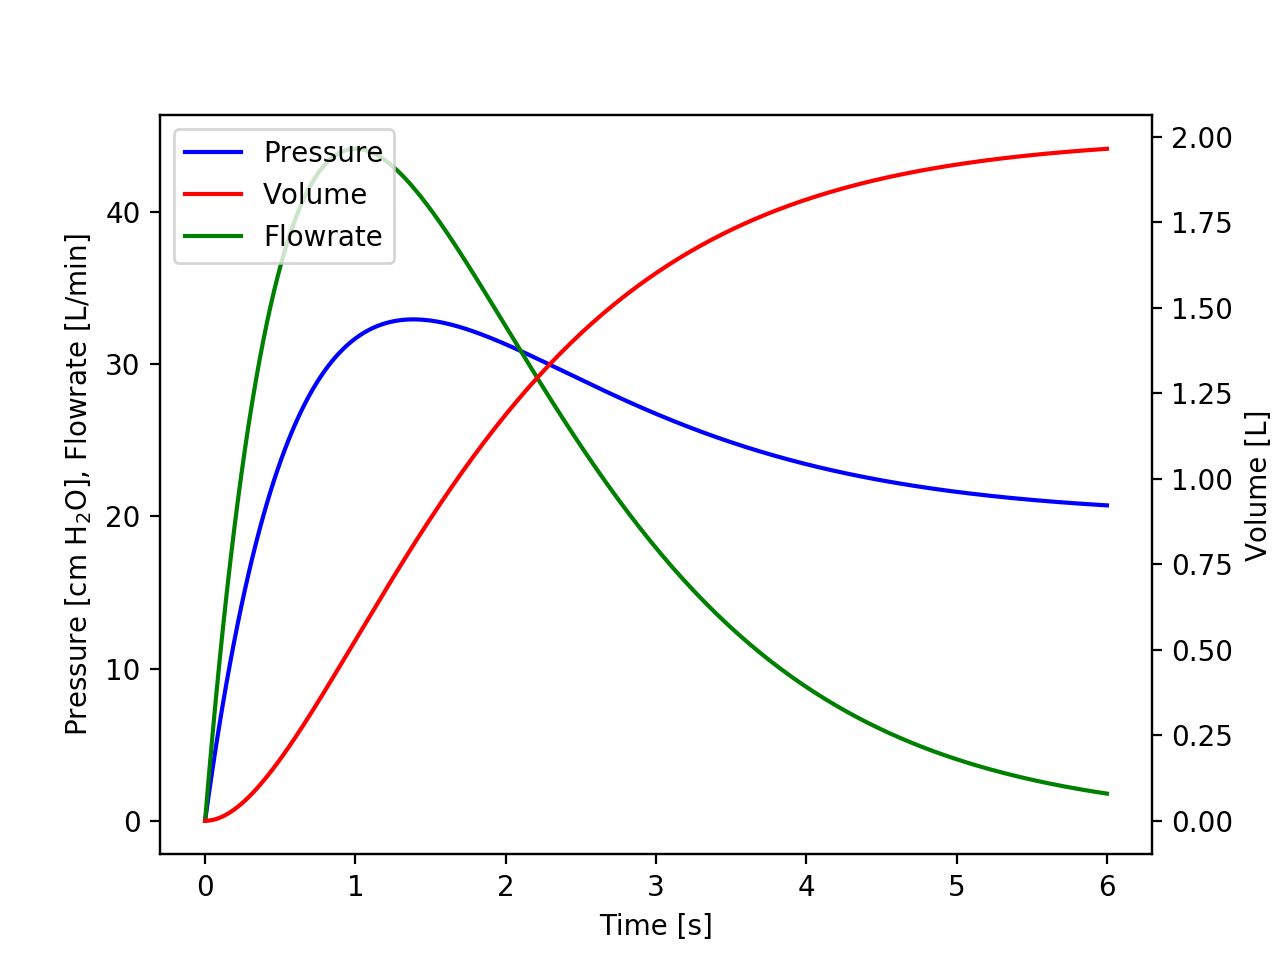

In [3]:
import numpy as np
import scipy.integrate as sint
import matplotlib.pyplot as plt
%matplotlib notebook

t = np.linspace(0,6,250) # seconds
#q = 0.1 * np.ones_like(t) # Litres per second
q = 2*t*np.exp(-t)
v = sint.cumtrapz(q,t,initial=0) # Litres

C = 0.1 #0.054 # patient compliance L/cmH2O
R = 13. # patient resistance 
Cv = 0.004 # tubing compliance
Rv = 22. # tubing resistance


tau = (R*C) + (Rv*Cv) + (Rv*C)
Ct = 1/((1/C)+(1/Cv))
print("tau = %.3f s"%tau)
print("Ctot = %.6f L/cmH2O" % Ct)
p = (tau*q/C) + (v/C)

fig=plt.figure()
ax=fig.add_subplot(111)
plt.xlabel('Time [s]')
p0,=ax.plot(t,p,c='b')
plt.ylabel('Pressure [cm H$_2$O], Flowrate [L/min]')
ax2=ax.twinx()
p1,=ax2.plot(t,v,c='r')
p2,=ax.plot(t,q*60,c='g')
plt.ylabel('Volume [L]')
plt.legend((p0,p1,p2),('Pressure','Volume','Flowrate'))
plt.show()

### New boundary condition

outlet_ur
    {
        /*
         Lung resistance and compliance function based on Plummer et al. (2020)

         Constants:
         - Ri, Re = Lung resistance during inspiration/expiration [L/cmH2O]
         - C      = Patient lung and airway compliance in ventilated range [cmH2O/(L/s)]
         - Rv, Cv = Tubing resistance and compliance
         - Vmax   = Total lung volume minus functional residual capacity [L]
         - PEEP   = Positive end expiratory pressure, typ. also equal to starting pressure [cmH2O]
         - pGauge = Offset from gauge pressure to absolute pressure, ie ~ atmospheric pressure
         - p0max  = ceiling stagnation pressure

         Calculated parameters:
         - v       = volume flowed [L]
         - q       = flowrate [L/s]
         - R       = instantaenous lung resistance [L/cmH2O]
         - Cc      = instantaneous airway compliance, allowing for increasing
                     stiffness approaching Vmax
         - tau     = time constant [s]
         - p0rc    = calculated outlet stagnation pressure [cmH2O]
         - p0pa    = converted absolute stagnation pressure [Pa]
        */

        type    groovyBC;
        valueExpression "p0lim - 0.5*rho*U&U";
        variables ( "C=0.1;"
                    "Ri=13.0;"
                    "Re=12.0;"
                    "Rv=22.0;"
                    "Cv=0.004;"
                    "Vmax=1.5;"
                    "PEEP=5.0;"
                    "pGauge=1e5;"
                    "p0max=103e3;"
                    "v=time()*sum(UMean&Sf())*1e3;"
                    "q=sum(U&Sf())*1e3;"
                    "R=(q>=0 ? Ri : Re);"
                    "Cc=(v<Vmax ? C : C*exp(-3*(v-Vmax)));"
                    "tau=(R*Cc)+(Rv*Cv)+(Rv*Cc);"
                    "p0rc=(tau*q/Cc)+(v/Cc)+PEEP;"
                    "p0pa=(p0rc*98.066)+pGauge;"
                    "p0lim=(p0pa < p0max ? p0pa : p0max);"
        );

        value uniform 100490.33; // initial value from time - varying inlet
    }
    
    outlet_wr
    {
        type    groovyBC;
        valueExpression "p0lim - 0.5*rho*U&U";
        variables ( "C=0.2;"
                    "Ri=13.0;"
                    "Re=12.0;"
                    "Rv=22.0;"
                    "Cv=0.004;"
                    "Vmax=1.5;"
                    "PEEP=5.0;"
                    "pGauge=1e5;"
                    "v=time()*sum(UMean&Sf())*1e3;"
                    "q=sum(U&Sf())*1e3;"
                    "p0max=103e3;"
                    "R=(q>=0 ? Ri : Re);"
                    "Cc=(v<Vmax ? C : C*exp(-3*(v-Vmax)));"
                    "tau=(R*Cc)+(Rv*Cv)+(Rv*Cc);"
                    "p0rc=(tau*q/Cc)+(v/Cc)+PEEP;"
                    "p0pa=(p0rc*98.066)+pGauge;"
                    "p0lim=(p0pa < p0max ? p0pa : p0max);"
        );

        value uniform 100490.33; // initial value from time - varying inlet
    }

### Original boundary condition

outlet_ur
    {
        /* 
         - This is a lung compliance simulation function.
         The concept is that the stagnation pressure at the patch rises proportionally to the volume flow rate
         through the patch. Compliance is set in Litres per cm of H2O and converted to SI units in the function.
         Tidal volume is in Litres but initial pressure is in Pascals.
         - Static pressure is set from a calculated stagnation pressure (gauge rel to 100 kPa)
         - Stagnation pressure at lung is set as integrated volume flow divided by compliance
         - integrated volume flow is determined as the time average volume flux multiplied by elapsed time
           Since flux is both patch-area and time-integrated, it should be stable against fluctuations.
         - Once the total volume flowed passes the tidal volume, the compliance becomes very small and the pressure
         will rise very quickly with further flow until such time as the pressure gradient vanishes and flow stops.

           Current settings:
                - 0 cmH2O gauge = 100 kpa abs.
                - Starting lung pressure is 100294.20 Pa to match inlet profile from experiment
                - Compliance of 0.1 L/cmH2O on the unrestricted port (a poor lung)
                - Compliance of 0.2 L/cmH2O on the restricted port (a healthy lung)
                - Max tidal volume of 0.5 L
                - Maximum allowed pressure of +41 cmH2O
        */

        type    groovyBC;
        valueExpression "(lung_p0g1 > 104e3 ? 104e3 : lung_p0g1) - 0.5*rho*U&U";
        variables (
                    "compliance1=0.1;"
                    "initial_pressure1=100294.20;"
                    "tidalVolume1=0.5;"
                    "integratedVolumetricFlow1=time()*sum(mag(UMean)*mag(Sf()));"
                    "limit1=((mag(integratedVolumetricFlow1)>tidalVolume1*1e-3) ? exp(10*(1 - mag(integratedVolumetricFlow1)*1e3/tidalVolume1)) : 1);"
                    "lung_p0g1=initial_pressure1+integratedVolumetricFlow1/(compliance1*limit1*1.01972e-5);"
        );

        value uniform 100294.20;
    }